<a href="https://colab.research.google.com/github/beruscoder/assignment_iisc/blob/main/VIT_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
IMAGE_SIZE = 32
BATCH_SIZE = 128

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

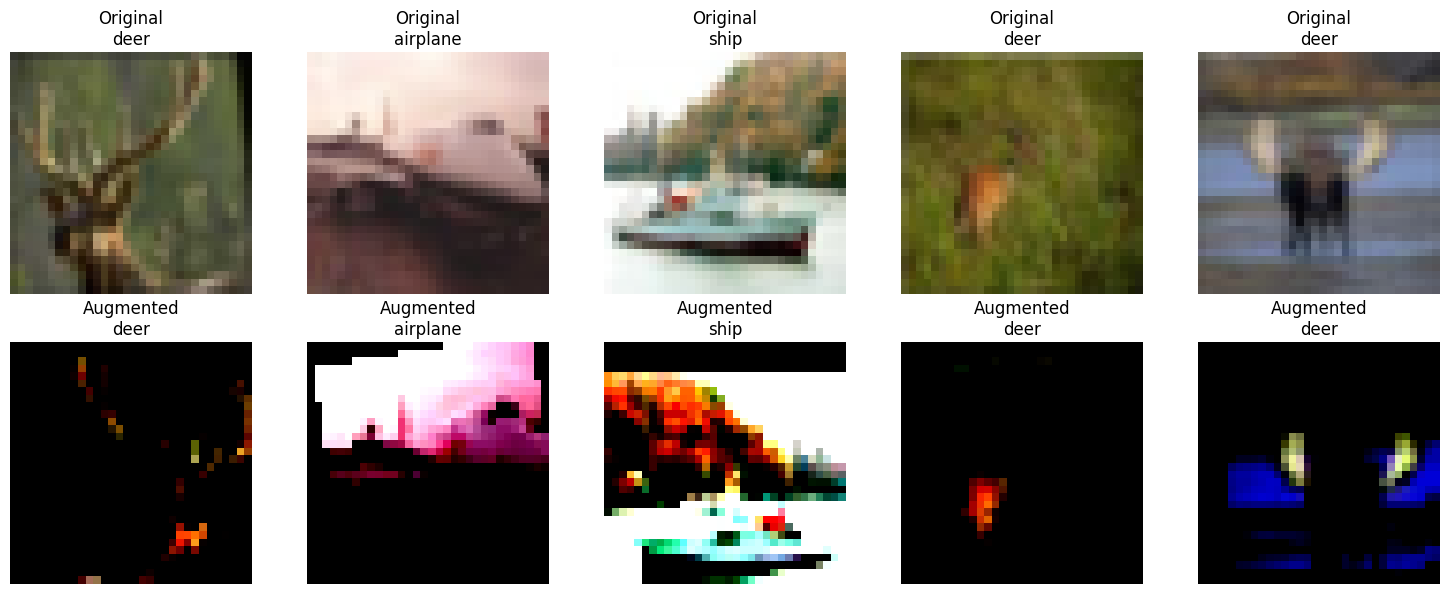

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch

# -----------------------------
# Original image transform (no augmentation)
# -----------------------------
original_transform = transforms.ToTensor()

# Load CIFAR-10 train dataset
train_original = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=original_transform)

# Load CIFAR-10 train dataset with augmentation
train_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)


# Function to display image
def imshow(img_tensor, ax):
    img = img_tensor.permute(1,2,0).numpy()  # convert [C,H,W] -> [H,W,C]
    # Clip image values to be between 0 and 1 for proper display
    img = img.clip(0, 1)
    ax.imshow(img)
    ax.axis('off')

# -----------------------------
# Pick 5 random images
# -----------------------------
num_images = 5
random_indices = torch.randint(0, len(train_original), (num_images,))

# Display original and augmented images in a 2x5 grid
fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
for i, idx in enumerate(random_indices):
    # Original image
    img_original, label = train_original[idx.item()]
    imshow(img_original, axes[0, i])
    axes[0, i].set_title(f"Original\n{train_original.classes[label]}")

    # Augmented image
    img_augmented, _ = train_augmented[idx.item()] # Use the same index for augmented image
    imshow(img_augmented, axes[1, i])
    axes[1, i].set_title(f"Augmented\n{train_augmented.classes[label]}")

plt.tight_layout()
plt.show()

In [ ]:
class HybridEmbed(nn.Module):
    def __init__(self, in_ch=3, embed_dim=256):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # [B,128,16,16]
        )
        self.proj = nn.Conv2d(128, embed_dim, kernel_size=4, stride=4)  # → [B,embed_dim,4,4]

    def forward(self, x):
        x = self.cnn(x)
        x = self.proj(x)  # [B, embed_dim, H/4, W/4]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, N, C]
        return x

In [ ]:
class ClassAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4.0, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=attn_drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        cls, patches = x[:, 0:1], x[:, 1:]
        cls_updated, _ = self.attn(self.norm1(cls), self.norm1(patches), self.norm1(patches))
        cls = cls + cls_updated
        cls = cls + self.mlp(self.norm2(cls))
        return torch.cat([cls, patches], dim=1)

In [ ]:
class HybridViT(nn.Module):
    def __init__(self, img_size=32, embed_dim=256, depth=6, num_heads=8, num_classes=10):
        super().__init__()
        self.patch_embed = HybridEmbed(in_ch=3, embed_dim=embed_dim)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, (img_size//8)*(img_size//8)+1, embed_dim))  # depends on patch count
        self.pos_drop = nn.Dropout(0.1)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # CLS refinement
        self.cls_refine_blocks = nn.ModuleList([ClassAttentionBlock(embed_dim, num_heads=num_heads) for _ in range(2)])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B,N,C]

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        x = self.transformer(x)

        for blk in self.cls_refine_blocks:
            x = blk(x)

        cls_token_final = self.norm(x[:, 0])
        out = self.head(cls_token_final)
        return out

In [ ]:
def train_model(model, trainloader, testloader, epochs=50, lr=3e-4):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(1, epochs+1):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for imgs, labels in trainloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

        train_acc = 100 * correct / total

        # Test
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in testloader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = outputs.max(1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()
        test_acc = 100 * correct / total

        print(f"Epoch {epoch}/{epochs} - Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | LR: {scheduler.get_last_lr()[0]:.6f}")
        scheduler.step()

    return model

# -----------------------------
# Run Training
# -----------------------------
model = HybridViT().to(device)
trained_model = train_model(model, trainloader, testloader, epochs=50, lr=3e-4)

Epoch 1/50 - Train Acc: 21.69% | Test Acc: 25.69% | LR: 0.000300
Epoch 2/50 - Train Acc: 34.39% | Test Acc: 43.96% | LR: 0.000300
Epoch 3/50 - Train Acc: 44.95% | Test Acc: 52.59% | LR: 0.000299
Epoch 4/50 - Train Acc: 53.48% | Test Acc: 58.28% | LR: 0.000297
Epoch 5/50 - Train Acc: 57.32% | Test Acc: 61.80% | LR: 0.000295
Epoch 6/50 - Train Acc: 60.89% | Test Acc: 65.32% | LR: 0.000293
Epoch 7/50 - Train Acc: 63.40% | Test Acc: 67.52% | LR: 0.000289
Epoch 8/50 - Train Acc: 65.24% | Test Acc: 70.96% | LR: 0.000286
Epoch 9/50 - Train Acc: 67.11% | Test Acc: 71.20% | LR: 0.000281
Epoch 10/50 - Train Acc: 68.60% | Test Acc: 71.56% | LR: 0.000277
Epoch 11/50 - Train Acc: 69.49% | Test Acc: 71.68% | LR: 0.000271
Epoch 12/50 - Train Acc: 71.32% | Test Acc: 75.55% | LR: 0.000266
Epoch 13/50 - Train Acc: 72.14% | Test Acc: 74.88% | LR: 0.000259
Epoch 14/50 - Train Acc: 73.23% | Test Acc: 76.16% | LR: 0.000253
Epoch 15/50 - Train Acc: 74.11% | Test Acc: 76.60% | LR: 0.000246
Epoch 16/50 - Train